In [ ]:
# https://blog.evjang.com/2016/11/tutorial-categorical-variational.html
# https://github.com/YongfeiYan/Gumbel_Softmax_VAE

# standard GS-VAE in reconstruction of MNIST unseen digits task
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Z_DIM = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 2
TAU = 1.0
TAU_DECAY = 0.95
MIN_TAU = 0.1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)

# removed digits 2 and 3 from training dataset:
train_dataset.data = train_dataset.data[(train_dataset.targets != 2) & (train_dataset.targets != 3)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets != 2) & (train_dataset.targets != 3)]
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# load testing dataset:
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 44247461.46it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1704216.29it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 12466052.00it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 757807.74it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# define a VAE with Gumbel Softmax distribution in latent spcae on MNIST
class GumbelVAE(nn.Module):
    def __init__(self):
        super(GumbelVAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(64 * 64, 512)
        self.fc_bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, Z_DIM)

        # Decoder layers
        self.fc4 = nn.Linear(Z_DIM, 256)
        self.fc_bn3 = nn.BatchNorm1d(256)
        self.fc5 = nn.Linear(256, 512)
        self.fc_bn4 = nn.BatchNorm1d(512)
        self.fc6 = nn.Linear(512, 64 * 64)

    def encode(self, x):
        h1 = F.relu(self.fc_bn1(self.fc1(x)))
        h2 = F.relu(self.fc_bn2(self.fc2(h1)))
        return self.fc3(h2)

    def reparameterize(self, logits, tau):
        z = F.gumbel_softmax(logits, tau=tau, hard=False)  # Gumbel Softmax distribution in latent spcae
        return z

    def decode(self, z):
        h3 = F.relu(self.fc_bn3(self.fc4(z)))
        h4 = F.relu(self.fc_bn4(self.fc5(h3)))
        return torch.sigmoid(self.fc6(h4))

    def forward(self, x, tau):
        logits = self.encode(x.view(-1, 64 * 64)) # x.view(-1, 64 * 64): each 64x64 image is converted into a flat 4096-element vector
        z = self.reparameterize(logits, tau)
        return self.decode(z), logits

# Wrongly used the Gaussian VAEs' KL divergence formula
# reference link: https://borisburkov.net/2022-12-31-1/
# def gumbel_vae_loss_function(recon_x, x, logits):
#     BCE = F.binary_cross_entropy(recon_x, x.view(-1, 64 * 64), reduction='sum')
#     KLD = -0.5 * torch.sum(1 + logits - logits.pow(2) - logits.exp())
#     return BCE + KLD

    # Gumbel-Softmax VAE loss function
    # reference link:  https://github.com/bojone/vae/blob/master/vae_keras_cnn_gs.py
    def gumbel_vae_loss_function(self, recon_x, x, logits):
      # Clamp the values of recon_x between 0 and 1
      recon_x = torch.clamp(recon_x, 0, 1)
      # Binary cross entropy
      BCE = F.binary_cross_entropy(recon_x, x.view(-1, 64 * 64), reduction='sum')
      BCE /= x.size(0)  # Average over batch
      # KL divergence for Gumbel-Softmax
      # q_y is the probability, dim = -1 means using softmax on the last dimension
      q_y = F.softmax(logits, dim=-1)
      # retrict the range to avoid the log(0)
      q_y = torch.clamp(q_y, torch.finfo(q_y.dtype).eps, 1 - torch.finfo(q_y.dtype).eps)  # to prevent log(0)
      # Finding KL divergence
      KLD = torch.sum(q_y * torch.log(q_y * Z_DIM), dim=-1).sum()
      return BCE + KLD


def train_gumbel_vae(model, optimizer, data_loader, tau):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(DEVICE)
        optimizer.zero_grad()
        recon_batch, logits = model(data, tau)
        loss = model.gumbel_vae_loss_function(recon_batch, data, logits)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(data_loader.dataset)
    return avg_loss


def test_gumbel_vae(model, data_loader, tau):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(DEVICE)
            recon_batch, logits = model(data, tau)
            test_loss += model.gumbel_vae_loss_function(recon_batch, data, logits).item()
    avg_loss = test_loss / len(data_loader.dataset)
    return avg_loss


In [ ]:
# train the Gubmel Softmax VAE:
gumbel_vae = GumbelVAE().to(DEVICE)
optimizer = torch.optim.Adam(gumbel_vae.parameters(), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    train_loss = train_gumbel_vae(gumbel_vae, optimizer, train_loader, TAU)
    test_loss = test_gumbel_vae(gumbel_vae, test_loader, TAU)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    TAU = max(TAU * TAU_DECAY, MIN_TAU)


data, _ = next(iter(test_loader))
data = data.to(DEVICE)
with torch.no_grad():
    recon_batch, _ = gumbel_vae(data, TAU)


Epoch 1, Train Loss: 923.7704, Test Loss: 907.6705
Epoch 2, Train Loss: 833.5676, Test Loss: 886.6422


In [ ]:
#save model
torch.save(gumbel_vae.state_dict(), 'gumbel_softmax_vae_model.pth')
torch.save(gumbel_vae, 'gumbel_softmax_vae_mnist_model_full.pth')

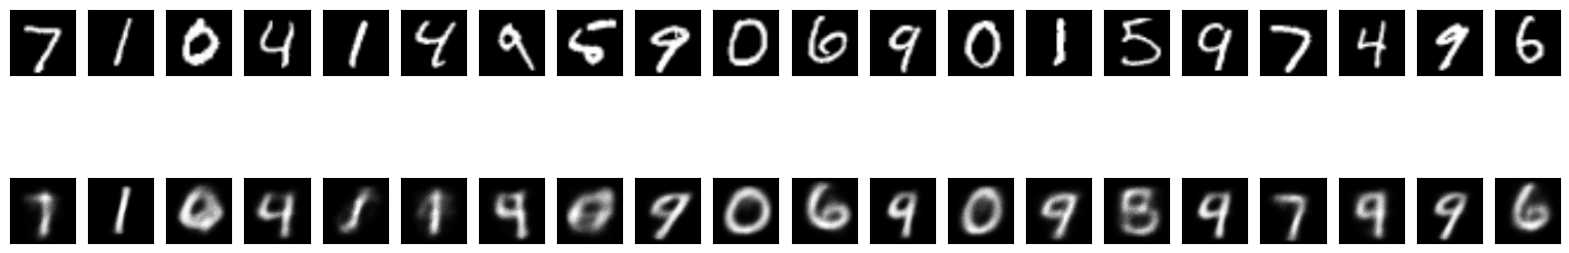

In [ ]:
# Remove digits 2 and 3 from the test dataset:
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)
test_dataset.data = test_dataset.data[(test_dataset.targets != 2) & (test_dataset.targets != 3)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets != 2) & (test_dataset.targets != 3)]
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

gumbel_vae.load_state_dict(torch.load('/content/gumbel_softmax_vae_model.pth'))

data, _ = next(iter(test_loader))
data = data.to(DEVICE)
with torch.no_grad():
    recon_batch, _ = gumbel_vae(data, TAU)  # use Gumbel-Softmax VAE for data reconstruction after training

def plot_images(original_images, reconstructed_images, n=20):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # First row: Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i][0].cpu(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Second row: Display reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        recon_image = reconstructed_images[i].view(64, 64).cpu()  # Reshape the tensor to 64x64
        plt.imshow(recon_image, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# For digits that have appeared in the training data (i.e., 0,1,4,5, ..., 9), you can see Gumbel-Softmax VAE can reconstruct data correctly with accuracy about 15/20 = 75%
plot_images(data.cpu(), recon_batch.cpu(), n=20)

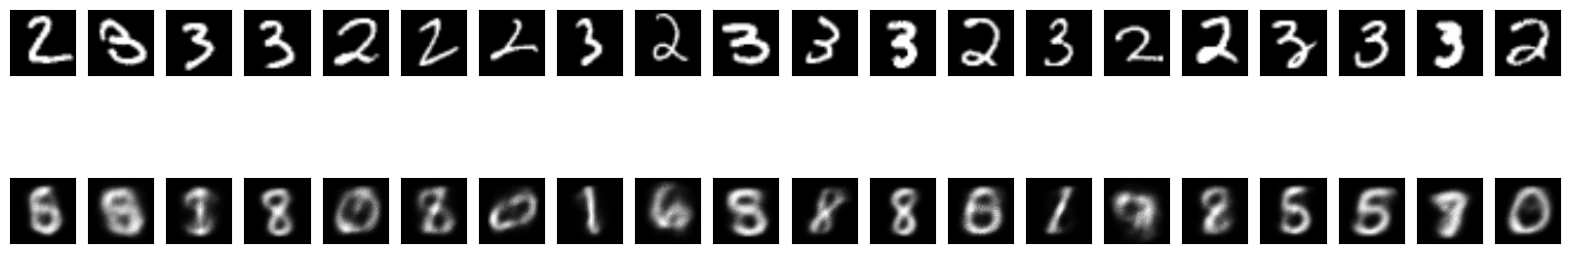

In [ ]:
# Let the test dataset contain digits 2 and 3 only:
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)
test_indices = (test_dataset.targets == 2) | (test_dataset.targets == 3)
test_dataset.data = test_dataset.data[test_indices]
test_dataset.targets = test_dataset.targets[test_indices]

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

gumbel_vae.load_state_dict(torch.load('/content/gumbel_softmax_vae_model.pth'))

data, _ = next(iter(test_loader))
data = data.to(DEVICE)
with torch.no_grad():
    recon_batch, _ = gumbel_vae(data, TAU)  # use Gumbel-Softmax VAE for data reconstruction after training

def plot_images(original_images, reconstructed_images, n=20):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i][0].cpu(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        recon_image = reconstructed_images[i].view(64, 64).cpu()  # Reshape the tensor to 64x64
        plt.imshow(recon_image, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# For digits 2 and 3 that have not appeared in the training dataset, Gumbel-Softmax VAE completely fails the reconstruction task:
plot_images(data.cpu(), recon_batch.cpu(), n=20)

In [ ]:
# The following is also a VAE, but with a Gaussian distribution for the latent space:
# Standard VAE (using Gaussian distribution for latent spcae) on MNIST
# Reference links:
# https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
# https://github.com/AntixK/PyTorch-VAE (This link includes lots of advanced VAEs)


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Z_DIM = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
# remove digits 2 and 3 from the training dataset:
train_dataset.data = train_dataset.data[(train_dataset.targets != 2) & (train_dataset.targets != 3)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets != 2) & (train_dataset.targets != 3)]
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class Gaussian_VAE(nn.Module):
    def __init__(self):
        super(Gaussian_VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(64 * 64, 512)
        self.fc_bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_bn2 = nn.BatchNorm1d(256)
        self.fc21 = nn.Linear(256, Z_DIM)
        self.fc22 = nn.Linear(256, Z_DIM)

        # Decoder layers
        self.fc3 = nn.Linear(Z_DIM, 256)
        self.fc_bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 512)
        self.fc_bn4 = nn.BatchNorm1d(512)
        self.fc5 = nn.Linear(512, 64 * 64)

    def encode(self, x):
        h1 = F.relu(self.fc_bn1(self.fc1(x)))
        h2 = F.relu(self.fc_bn2(self.fc2(h1)))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):  # using Gaussian distribution
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc_bn3(self.fc3(z)))
        h4 = F.relu(self.fc_bn4(self.fc4(h3)))
        return torch.sigmoid(self.fc5(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 64 * 64)) # each 64x64 image is converted into a flat 4096-element vector
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 64 * 64), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train_vae(model, optimizer, data_loader):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(DEVICE)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(data_loader.dataset)
    return avg_loss

def test_vae(model, data_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(DEVICE)
            recon_batch, mu, logvar = model(data)
            test_loss += vae_loss_function(recon_batch, data, mu, logvar).item()
    avg_loss = test_loss / len(data_loader.dataset)
    return avg_loss


In [ ]:
gaussian_vae = Gaussian_VAE().to(DEVICE)
optimizer = torch.optim.Adam(gaussian_vae.parameters(), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    train_loss = train_vae(gaussian_vae, optimizer, train_loader)
    test_loss = test_vae(gaussian_vae, test_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 1, Train Loss: 682.1705, Test Loss: 592.9829
Epoch 2, Train Loss: 534.5923, Test Loss: 556.0002


In [ ]:
#save model
torch.save(gaussian_vae.state_dict(), 'gaussian_vae_model.pth')
torch.save(gaussian_vae, 'gaussian_vae_mnist_model_full.pth')

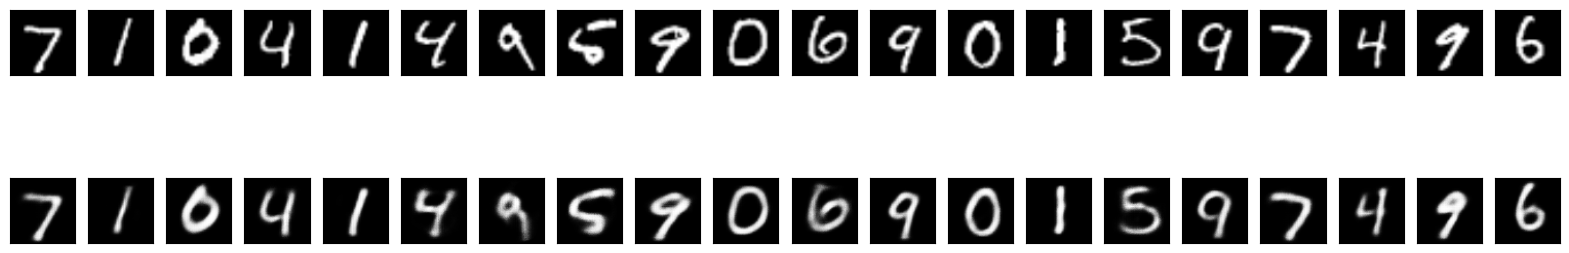

In [ ]:
# Remove digits 2 and 3 from the test dataset:
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)
test_dataset.data = test_dataset.data[(test_dataset.targets != 2) & (test_dataset.targets != 3)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets != 2) & (test_dataset.targets != 3)]
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

gaussian_vae.load_state_dict(torch.load('/content/gaussian_vae_model.pth'))

data, _ = next(iter(test_loader))
data = data.to(DEVICE)
with torch.no_grad():
    recon_batch, _, _ = gaussian_vae(data)  # use Gaussina VAE for data reconstruction after training

# only the digits 2 and 3，the traditional VAE cannot reconstruct the unseen data
SEED = 1
torch.manual_seed(SEED)
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
def plot_images(original_images, reconstructed_images, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i][0].cpu(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        recon_image = reconstructed_images[i].view(64, 64).cpu()  # Reshape the tensor to 64x64
        plt.imshow(recon_image, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# For digits excluding 2 and 3, you can see Gaussian-VAE can reconstruct data correctly with accuracy about 19/20 = 95%
plot_images(data.cpu(), recon_batch.cpu(), n=20)

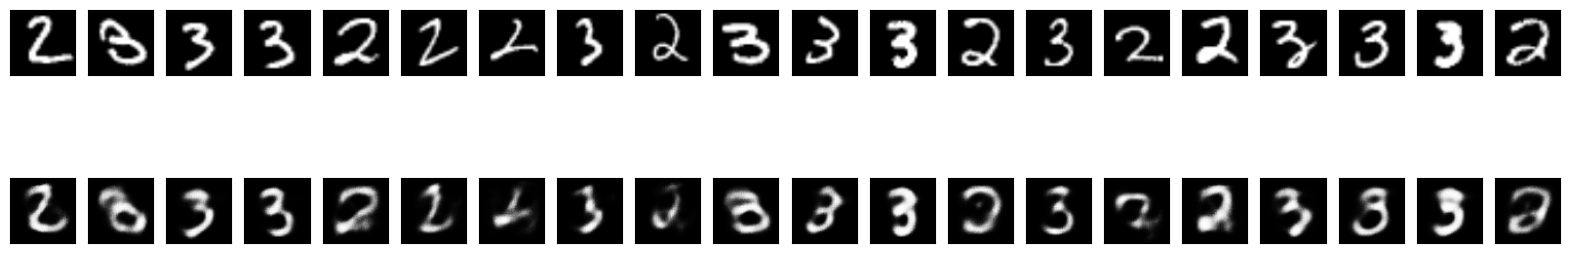

In [ ]:
# Only keep digits 2 and 3 in the test dataset:
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)
test_indices = (test_dataset.targets == 2) | (test_dataset.targets == 3)
test_dataset.data = test_dataset.data[test_indices]
test_dataset.targets = test_dataset.targets[test_indices]
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

gaussian_vae.load_state_dict(torch.load('/content/gaussian_vae_model.pth'))

data, _ = next(iter(test_loader))
data = data.to(DEVICE)
with torch.no_grad():
    recon_batch, _, _ = gaussian_vae(data)  # use Gaussina VAE for data reconstruction after training


# only the digits 2 and 3，the traditional VAE cannot reconstruct the unseen data
SEED = 1
torch.manual_seed(SEED)
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
def plot_images(original_images, reconstructed_images, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i][0].cpu(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        recon_image = reconstructed_images[i].view(64, 64).cpu()  # Reshape the tensor to 64x64
        plt.imshow(recon_image, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# For digits 2 and 3 that have not appeared in the training dataset, you can see that somehow Gaussian-VAE can reconstruct data!
plot_images(data.cpu(), recon_batch.cpu(), n=20)